#### Optional Code for running in Collab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os

# Path to your project folder in Drive
project_path = '/content/drive/MyDrive/WASL-translator'

# Change working directory
os.chdir(project_path)

# Confirm structure
print("Current working dir:", os.getcwd())
!ls -R data/raw | head -20

##### For pulling new changes

In [ ]:
!cd /content/drive/MyDrive/WASL-translator && git pull

### 1. Load the dataset 
Loaded from .../data/raw/

In [1]:
# Import dataset loader (Debug version)
import sys, os
sys.path.append(os.path.abspath("../src"))
from utils import dataset_loader
import importlib
importlib.reload(dataset_loader)

X_train, y_train, X_test, y_test = dataset_loader.load_dataset("../data/raw", debug=False)


Loading A...
Loading B...
Loading C...
Loading D...
Loading del...
Loading E...
Loading F...
Loading G...
Loading H...
Loading I...
Loading J...
Loading K...
Loading L...
Loading M...
Loading N...
Loading nothing...
Loading O...
Loading P...
Loading Q...
Loading R...
Loading S...
Loading space...
Loading T...
Loading U...
Loading V...
Loading W...
Loading X...
Loading Y...
Loading Z...
Loaded 87000 training images across 29 classes.
Loaded 28 test images across 28 labels.
Loaded dataset_loader from: e:\Ashwin\importantFiles\Programming Projects\WASL-translator\src\utils\dataset_loader.py
Train label set: ['a', 'b', 'c', 'd', 'del', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'nothing', 'o', 'p', 'q', 'r', 's', 'space', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Test label set: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'nothing', 'o', 'p', 'q', 'r', 's', 'space', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Unseen in test: set()


In [2]:
# Import dataset loader
import sys, os
sys.path.append(os.path.abspath("../src"))

from utils.dataset_loader import load_dataset

# Load raw data
root_dir = "../data/raw"
X_train, y_train, X_test, y_test = load_dataset(root_dir)


Loading A...
Loading B...
Loading C...
Loading D...
Loading del...
Loading E...
Loading F...
Loading G...
Loading H...
Loading I...
Loading J...
Loading K...
Loading L...
Loading M...
Loading N...
Loading nothing...
Loading O...
Loading P...
Loading Q...
Loading R...
Loading S...
Loading space...
Loading T...
Loading U...
Loading V...
Loading W...
Loading X...
Loading Y...
Loading Z...
Loaded 87000 training images across 29 classes.
Loaded 28 test images across 28 labels.
Loaded dataset_loader from: e:\Ashwin\importantFiles\Programming Projects\WASL-translator\src\utils\dataset_loader.py
Train label set: ['a', 'b', 'c', 'd', 'del', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'nothing', 'o', 'p', 'q', 'r', 's', 'space', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Test label set: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'nothing', 'o', 'p', 'q', 'r', 's', 'space', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Unseen in test: set()


### 2. Preprocess data
Resize and convert to grayscale --> (Optional Gaussian Blur) --> Select Edge Detector --> (Optional Otsu Thresholding) --> Normalise --> Label Encoding


##### 2.1 Preprocessing Functions

In [28]:
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

def resize_grayscale(images, target_size=(64, 64), grayscale=True):
    processed = []
    for img in images:
        # Resize to 64x64 pixels square using weighted average
        img = cv2.resize(img, target_size)
        # Convert to grayscale to save space and reduce complexity
        if grayscale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = np.expand_dims(img, axis=-1)

        processed.append(img)
    return np.array(processed)

# Give labels numerical values
def encode_labels(labels):

    encoder = LabelEncoder()
    encoded = encoder.fit_transform(labels)
    return encoded, encoder

def edge_detector(img, method="none"):

    if method == "sobel":
        # use 64bit float to keep negative gradients 3 kernels to keep a localised window, combine with magnitude
        gx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
        gy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
        img = cv2.magnitude(gx, gy)

    elif method == "prewitt":
        # manually create 3x3 kernel and apply it with filter2D, use magnitude to combine
        kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
        kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
        gx = cv2.filter2D(img, -1, kernelx)
        gy = cv2.filter2D(img, -1, kernely)
        img = cv2.magnitude(gx.astype(np.float32), gy.astype(np.float32))

    elif method == "roberts":
        # manually create 2x2 kernel and apply it with filter2D, use magnitude to combine
        kernelx = np.array([[1, 0], [0, -1]])
        kernely = np.array([[0, 1], [-1, 0]])
        gx = cv2.filter2D(img, -1, kernelx)
        gy = cv2.filter2D(img, -1, kernely)
        img = cv2.magnitude(gx.astype(np.float32), gy.astype(np.float32))

    return img

def threshold_otsu(img):
    # normalise to uint8 (for 0-255), ignore first return value
    img_uint8 = (img * 255).astype(np.uint8)
    _, img_thresh = cv2.threshold(img_uint8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    img_thresh = img_thresh.astype(np.float32) / 255.0
    return img_thresh

def gaussian_blur(img, kernel_size=(5, 5), sigma=0):
    return cv2.GaussianBlur(img, kernel_size, sigma)



##### 2.2 Perform Preprocessing

In [75]:
# Run this cell first
X_train_transform = resize_grayscale(X_train, target_size=(64,64))
X_test_transform  = resize_grayscale(X_test,  target_size=(64,64))
X_train_proc, X_test_proc = X_train_transform, X_test_transform
print("transform and converted to grayscale")


transform and converted to grayscale


In [ ]:
# Gaussian Blur
use_gaussian_blur = True
if use_gaussian_blur:
    X_train_proc = np.array([gaussian_blur(img) for img in X_train_proc])
    X_test_proc  = np.array([gaussian_blur(img) for img in X_test_proc])
    print("Gaussian blur applied")
else:
    print("Gaussian blur not applied")

In [76]:
# Change to required edge detection method
edge_method = "roberts"  # "none", "sobel", "prewitt", "roberts"
if edge_method != "none":
    X_train_proc = np.array([edge_detector(img, method=edge_method) for img in X_train_proc])
    X_test_proc  = np.array([edge_detector(img, method=edge_method) for img in X_test_proc])
    print(f"Edge detection applied: {edge_method}")
else:
    print("No edge detection applied")

Edge detection applied: roberts


In [ ]:
apply_otsu = True
if apply_otsu:
    X_train_proc = np.array([threshold_otsu(img) for img in X_train_proc])
    X_test_proc  = np.array([threshold_otsu(img) for img in X_test_proc])
    print("Otsu threshold applied")
else:
    print("No Otsu threshold applied")

In [77]:
# Run this always to add back channel then normalize to 0–1
if X_train_proc.ndim == 3:
    X_train_proc = np.expand_dims(X_train_proc, axis=-1)
    X_test_proc = np.expand_dims(X_test_proc, axis=-1)


X_train_final = X_train_proc.astype("float32") / 255.0
X_test_final  = X_test_proc.astype("float32") / 255.0
print("Normalised with shape:", X_train_final.shape)

Normalised with shape: (87000, 64, 64, 1)


In [78]:
# Run this always to encode labels
y_train_enc, label_encoder = encode_labels(y_train)
y_test_enc = label_encoder.transform(y_test)
print("Labels encoded")

Labels encoded


In [79]:
# Save the label encoder for future use
import joblib
joblib.dump(label_encoder, "../data/processed/label_encoder.pkl")
print("Label encoder saved!")

Label encoder saved!


In [80]:
# Save processed data to be used for model
np.save("../data/processed/X_train_processed.npy", X_train_final)
np.save("../data/processed/X_test_processed.npy", X_test_final)
np.save("../data/processed/y_train_encoded.npy", y_train_enc)
np.save("../data/processed/y_test_encoded.npy", y_test_enc)

print("Saved processed datasets")

Saved processed datasets


### 3. Save processed data and Show example imgs
Saved into: .../data/processed/

##### 3.1 Visualise Function

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import cv2, os

def show_custom_samples(images, labels, label_encoder, special_classes=["nothing", "del", "space"], num_alpha=2):
    classes = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

    # Convert label integers back to text
    text_labels = label_encoder.inverse_transform(labels)

    selected_indices = []

    # Grab 1 from each special class
    for sc in special_classes:
        idx = np.where(text_labels == sc)[0]
        if len(idx) > 0:
            selected_indices.append(idx[0])

    # Get alphabet classes (exclude special)
    alphabet_classes = [c for c in classes if c not in special_classes]

    # Pick 2 letters (first two alphabet classes)
    picked_letters = alphabet_classes[:num_alpha]

    for letter in picked_letters:
        idx = np.where(text_labels == letter)[0]
        if len(idx) > 0:
            selected_indices.append(idx[0])

    # Plot
    plt.figure(figsize=(12, 4))
    for i, idx in enumerate(selected_indices):
        img = images[idx]
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img.squeeze()

        plt.subplot(1, len(selected_indices), i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(text_labels[idx])
        plt.axis("off")

    plt.show()
    

def save_custom_samples(images, labels, label_encoder, out_dir="preview_5"):
    os.makedirs(out_dir, exist_ok=True)

    classes = label_encoder.inverse_transform(range(len(label_encoder.classes_)))
    text_labels = label_encoder.inverse_transform(labels)

    selected = []
    for cls in ["nothing", "del", "space"]:
        idx = np.where(text_labels == cls)[0]
        if len(idx) > 0:
            selected.append(idx[0])

    alpha_classes = [c for c in classes if c not in ["nothing", "del", "space"]]
    for cls in alpha_classes[:2]:
        idx = np.where(text_labels == cls)[0]
        if len(idx) > 0:
            selected.append(idx[0])

    for idx in selected:
        img = images[idx]
        name = text_labels[idx]
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img.squeeze()

        # invert so white hand = white hand (same as plt)
        img_uint8 = (img * 255).astype(np.uint8)
        img_uint8 = 255 - img_uint8
        cv2.imwrite(os.path.join(out_dir, f"{name}.png"), img_uint8)

    print(f"Saved 5 samples to {out_dir}/")

def save_edge_samples(images, labels, label_encoder, out_dir="preview_edges"):
    os.makedirs(out_dir, exist_ok=True)

    classes = label_encoder.inverse_transform(range(len(label_encoder.classes_)))
    text_labels = label_encoder.inverse_transform(labels)

    # pick 3 special + 2 alphabet samples
    selected = []
    for cls in ["nothing", "del", "space"]:
        idx = np.where(text_labels == cls)[0]
        if len(idx) > 0:
            selected.append(idx[0])

    alpha_classes = [c for c in classes if c not in ["nothing", "del", "space"]]
    for cls in alpha_classes[:2]:
        idx = np.where(text_labels == cls)[0]
        if len(idx) > 0:
            selected.append(idx[0])

    for idx in selected:
        img = images[idx]
        label = text_labels[idx]

        # squeeze (N,64,64,1) → (64,64)
        if img.ndim == 3 and img.shape[-1] == 1:
            img = img.squeeze()

        # Normalize for edge maps (handles negative Sobel values too)
        img_norm = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
        img_uint8 = img_norm.astype(np.uint8)

        cv2.imwrite(os.path.join(out_dir, f"{label}.png"), img_uint8)

    print(f"Saved 5 edge images to {out_dir}/")



##### 3.2 Generate and Save Images

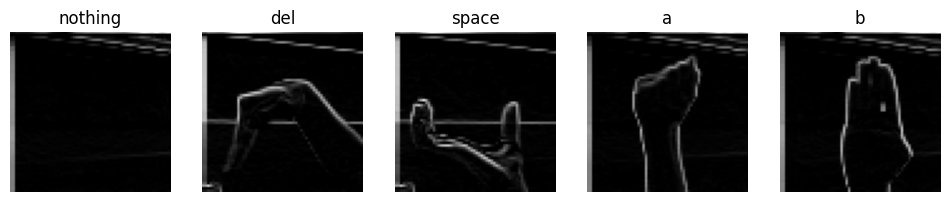

In [81]:
show_custom_samples(X_train_proc, y_train_enc, label_encoder)

In [74]:
save_custom_samples(X_train_proc, y_train_enc, label_encoder)

Saved 5 samples to preview_5/


##### Use this to save any edge detector runs

In [82]:
save_edge_samples(X_train_proc, y_train_enc, label_encoder)

Saved 5 edge images to preview_edges/
